# Ejercicio 2

El objetivo de este ejercicio es que el alumno se familiarice con técnicas para evaluar la calidad de los clusters generados. Además, que analice los resultados de aplicar técnicas de `feature extraction` para reducir dimensiones. Finalmente, que el estudiante analice los efectos del escalamiento de datos.

## Ejercicio 2.1 

Ejecute y analice el siguiente código

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set()
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv("vehicle.csv")

# se transforma la columna de clase a valores enteros
df["class"] = df["class"].astype('category').cat.codes

In [3]:
df.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,3
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,3
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,2
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,3
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,0


In [6]:
max(df["circularity"])

59

In [7]:
min(df["circularity"])

33

In [5]:
# se crea la matriz de valores y las etiquetas de los clusters
x = df.to_numpy()[:, :-1]
clusters = df.to_numpy()[:, -1]

In [6]:
# se re-escalan los datos para que las columnas con valores más altos, no dominen los cálculos
#Ofrece mejores resultados cuando se re-escalan los datos
#scaler = MinMaxScaler()
#x = scaler.fit_transform(x)

In [7]:
def cluster_ac(x, n_clusters):
    #Agrupa los objetos similares para formar un cluster que esta usando la distancia euclidiana para formar el cluster
    #Con linkage='ward' se utiliza la minimizacion de la variaza de dos clusters ward es para 2
    ac = cluster.AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    #Se realiza el entrenamientio
    ac.fit(x)
    return ac.labels_


def cluster_dbscan(x):
    #Agrupa los clusterings por densidad usando la estimacion de densidad de nodos correspondientes
    #Usado para detectar clusters de elementos proximos los paarmetros de eps son parametros que se consideran a prueba y error
    #usando la metrica euclidiana eps= 0.3 es la maxima distncia entre dos ejemplos de una consideracion vecinos a otros
    db = cluster.DBSCAN(metric='euclidean', eps=0.3)
    db.fit(x)
    return db.labels_


def cluster_kmeans(x, n_clusters):
    #Agrupa objetos basandose en la cantidad de clusters
    #
    return cluster.k_means(x, n_clusters=n_clusters)[1]

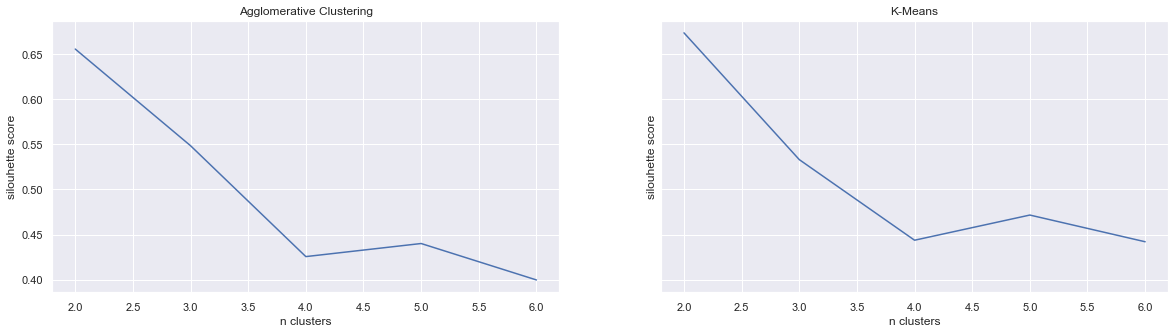

In [8]:
def calcular_silhouette(x, c):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
    
    methodos = [cluster_ac, cluster_kmeans]
    for i, m in enumerate(methodos):
        res = []
        for c in range(2, 7):
            #Es la mejor manera de decidir el numero de clusters para los datos
            res += [silhouette_score(x, m(x, c))]
            
        ax[i].plot(range(2, 7), res)
        ax[i].set_xlabel("n clusters")
        ax[i].set_ylabel("silouhette score")
        ax[i].set_title('Agglomerative Clustering' if i==0 else "K-Means")
        


calcular_silhouette(x, clusters)

## Ejercicio 2.2 

¿Qué número de clusters elegiría? ¿Por que?

## Ejercicio 2.3 

PCA y TSNE son técnicas de `feature extraction` que transforman el dataset a una dimensionalidad menor, intentando mantener la mayor cantidad de información; y de esta manera, encontrar la dimensionalidad intrínseca del dataset.  

Ejecute el código a continuación y analice los resultados. Primero ejecute el código tal y como está. Luego modifique el parámetro `how` de la función `reducir_dataset` por el valor "pca" y luego por "tsne"

In [9]:
#Son funciones para reducir el numero de dimensiones
def reducir_dim(x, ndim):
    pca = PCA(n_components=ndim)
    return pca.fit_transform(x)


def reducir_dim_tsne(x, ndim):
    pca = TSNE(n_components=ndim)
    return pca.fit_transform(x)


def reducir_dataset(x, how="tsne"):
    if how == "pca":
        res = reducir_dim(x, ndim=2)
    elif how == "tsne":
        res = reducir_dim_tsne(x, ndim=2)
    else:
        res = x[:, :2]

    return res

# se ejecutan algoritmos de clusterings con la configuración que le parezca más idónea
#En este se pasan los datos y el numero de clusters calculados en silouhette score
clus_ac = cluster_ac(x, 2)
clus_km = cluster_kmeans(x, 2)
#BSCAN es un metodo que no necesita el numero de clusers el da ese valor automaticamente, no siempre es el mejor
clus_db = cluster_dbscan(x)

# se concatenan los resultados en un dataframe se debe de cambiar el valor de how para ver cual
results = pd.DataFrame(np.column_stack([reducir_dataset(x, how="tsne"), clusters, clus_ac, clus_km, clus_db]), 
                      columns=["x", "y", "clusters", "clus_ac", "clus_km", "clus_db"])

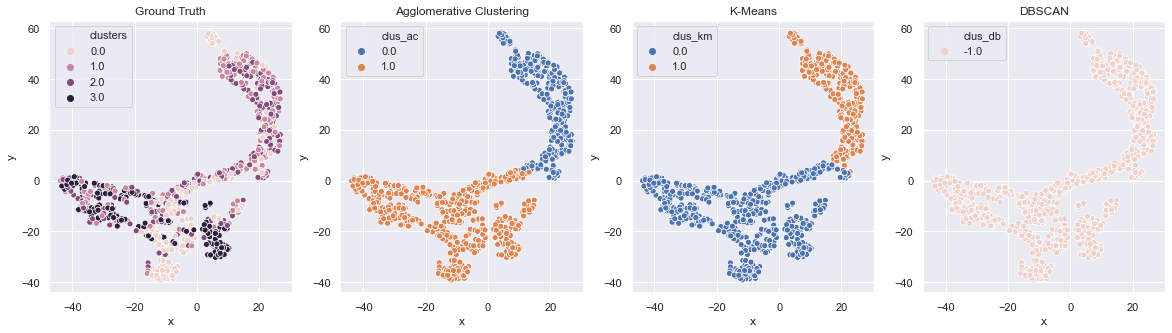

In [10]:
def mostrar_resultados(res):
    """Muestra los resultados de los algoritmos
    """
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    sns.scatterplot(data=res, x="x", y="y", hue="clusters", ax=ax[0], legend="full")
    ax[0].set_title('Ground Truth')
    sns.scatterplot(data=res, x="x", y="y", hue="clus_ac", ax=ax[1], legend="full")
    ax[1].set_title('Agglomerative Clustering')
    sns.scatterplot(data=res, x="x", y="y", hue="clus_km", ax=ax[2], legend="full")
    ax[2].set_title('K-Means')
    sns.scatterplot(data=res, x="x", y="y", hue="clus_db", ax=ax[3], legend="full")
    ax[3].set_title('DBSCAN')
    

mostrar_resultados(results)

¿Alguna de las 2 transformaciones: PCA o TSNE ayudó a visualizar de mejor manera los clusters generados?<br>

Explique sus observaciones.

## Ejercicio 2.4

Comparando el gráfico con las clases orignales del problema ("ground truth") y las particiones obtenidas por los algoritmos de clustering:

- ¿Se pudieron recrear las particiones iniciales?
- ¿Por que si, o por que no?
- ¿PCA o TSNE ayudó de alguna manera a mejorar la visualización del dataset? ¿Cómo?

## Ejercicio 2.5

Genere un gráfico como el del ejercicio 2.3 pero esta vez no ejecute el escalamiento de datos. 

¿Existe alguna diferencia en el resultado?